In [1]:
import pandas, scipy, numpy, seaborn
import matplotlib, matplotlib.pyplot as plt

import pybiomart
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [20]:
#data all_counts_filtered
df = pandas.read_csv(file_directory+'1) input/HEK293_temp_transcript_all_counts_unfiltered_v2.tsv',
                     sep = '\t')
print(df.shape)
df.head()

(135603, 9)


,gene_id,gene_name,feature_id,s37rep2,s32rep3,s37rep1,s37rep3,s32rep1,s32rep2
0,ENSG00000198034,RPS4X,ENST00000316084,232646,199874,190685,196125,160799,177622
1,ENSG00000142937,RPS8,ENST00000396651,191357,163277,156765,160123,133777,150626
2,ENSG00000182774,RPS17,ENST00000647841,188996,163258,157911,153051,133896,156007
3,ENSG00000229117,RPL41,ENST00000546591,182501,170503,142081,168055,126151,146154
4,ENSG00000142937,RPS8,ENST00000485390,182336,155347,148909,154214,126332,142296


In [12]:
# Import data from hsapiens_gene_ensembl
dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
annotation = dataset.query(attributes=['external_gene_name', 'external_transcript_name', 'ensembl_gene_id', 'ensembl_transcript_id',
                                       'gene_biotype', 'transcript_biotype', 'description'])

annotation = annotation.rename(columns = {'Gene stable ID' : 'gene_id',
                                   'Transcript stable ID' : 'transcript_id'})

annotation.set_index('transcript_id', drop=True, inplace=True)
# annotation.set_index('Gene stable ID', inplace=True)
annotation.head(2)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description
transcript_id,,,,,,
ENST00000387314,MT-TF,MT-TF-201,ENSG00000210049,Mt_tRNA,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
ENST00000389680,MT-RNR1,MT-RNR1-201,ENSG00000211459,Mt_rRNA,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:HGNC ...


# III] Data transformation

In [21]:
# Organize the df
df = df.rename(columns = {'feature_id' : 'transcript_id'})
df.set_index('transcript_id', drop=True, inplace=True)
df = df.drop(['gene_name', 'gene_id'], axis=1)

# It's not the good column order
df = df[['s37rep1', 's37rep2', 's37rep3', 's32rep1', 's32rep2', 's32rep3']]
df.head()

,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
transcript_id,,,,,,
ENST00000316084,190685,232646,196125,160799,177622,199874
ENST00000396651,156765,191357,160123,133777,150626,163277
ENST00000647841,157911,188996,153051,133896,156007,163258
ENST00000546591,142081,182501,168055,126151,146154,170503
ENST00000485390,148909,182336,154214,126332,142296,155347


In [22]:
# Remove the non expressed transcripts (less than 10 counts)
full_leng = len(df)
df = df[df.max(axis=1) >= 10]

filtr_leng = len(df)
dropped_transcripts = full_leng - filtr_leng

print(f'On {full_leng}, {dropped_transcripts} transcripts do not exceed 10 counts')

df = df.T
df

On 135603, 68143 transcripts do not exceed 10 counts


transcript_id,ENST00000316084,ENST00000396651,ENST00000647841,ENST00000546591,ENST00000485390,ENST00000501597,ENST00000598742,ENST00000600467,ENST00000221975,ENST00000593863,...,ENST00000566034,ENST00000293894,ENST00000651659,ENST00000307940,ENST00000575854,ENST00000648570,ENST00000395360,ENST00000479866,ENST00000698386,ENST00000429967
s37rep1,190685,156765,157911,142081,148909,140774,147451,147063,145697,135375,...,2,2,2,1,1,1,0,0,0,0
s37rep2,232646,191357,188996,182501,182336,180643,178746,178019,176662,163895,...,0,0,0,0,0,0,0,0,0,0
s37rep3,196125,160123,153051,168055,154214,166821,152260,151708,150615,139180,...,7,7,4,0,2,16,24,12,4,1
s32rep1,160799,133777,133896,126151,126332,125378,126652,126273,125238,115231,...,3,3,1,1,11,0,0,0,10,11
s32rep2,177622,150626,156007,146154,142296,145483,138197,137659,136606,127173,...,10,10,13,10,5,1,0,1,4,1
s32rep3,199874,163277,163258,170503,155347,169772,147436,146893,145794,134928,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Preapre the deseq2 metadata
metadata = pandas.DataFrame(zip(df.index, ['37°','37°','37°','32°', '32°', '32°']),
                            columns = ['Sample', 'Condition'])

metadata = metadata.set_index('Sample')
metadata

,Condition
Sample,
s37rep1,37°
s37rep2,37°
s37rep3,37°
s32rep1,32°
s32rep2,32°
s32rep3,32°


In [24]:
%%time
# define the data
dds = DeseqDataSet(counts = df,
                   metadata = metadata,
                   design_factors = "Condition")
print(dds)

#run deseq2
dds.deseq2()

#show results, The name provided in the second element is the level that is used as baseline. 
stat_res = DeseqStats(dds, contrast = ('Condition', '32°', '37°'))

AnnData object with n_obs × n_vars = 6 × 67460
    obs: 'Condition'
    obsm: 'design_matrix'


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 22.09 seconds.

Fitting dispersion trend curve...
... done in 3.33 seconds.

Fitting MAP dispersions...
... done in 21.34 seconds.

Fitting LFCs...


CPU times: total: 29.2 s
Wall time: 1min 28s


... done in 12.94 seconds.

Refitting 0 outliers.



In [25]:
#save results in a df
stat_res.summary()

res = stat_res.results_df
res

Running Wald tests...
... done in 6.83 seconds.



Log2 fold change & Wald test p-value: Condition 32° vs 37°
                      baseMean  log2FoldChange     lfcSE      stat    pvalue  \
transcript_id                                                                  
ENST00000316084  191445.754149        0.166710  0.237639  0.701529  0.482973   
ENST00000396651  158035.042472        0.184380  0.233656  0.789108  0.430049   
ENST00000647841  157570.432134        0.227071  0.228550  0.993528  0.320453   
ENST00000546591  155707.749717        0.210090  0.256955  0.817615  0.413577   
ENST00000485390  150346.682757        0.171633  0.235535  0.728697  0.466187   
...                        ...             ...       ...       ...       ...   
ENST00000648570       3.044330       -3.844121  2.951246 -1.302542  0.192731   
ENST00000395360       4.117304       -5.327108  4.210418 -1.265221  0.205792   
ENST00000479866       2.225072       -3.362734  3.995841 -0.841558  0.400035   
ENST00000698386       3.133925        1.868918  2.686408  0.6

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,
ENST00000316084,191445.754149,0.166710,0.237639,0.701529,0.482973,0.926364
ENST00000396651,158035.042472,0.184380,0.233656,0.789108,0.430049,0.912718
ENST00000647841,157570.432134,0.227071,0.228550,0.993528,0.320453,0.880298
ENST00000546591,155707.749717,0.210090,0.256955,0.817615,0.413577,0.908170
ENST00000485390,150346.682757,0.171633,0.235535,0.728697,0.466187,0.922093
...,...,...,...,...,...,...
ENST00000648570,3.044330,-3.844121,2.951246,-1.302542,0.192731,NaN
ENST00000395360,4.117304,-5.327108,4.210418,-1.265221,0.205792,NaN
ENST00000479866,2.225072,-3.362734,3.995841,-0.841558,0.400035,NaN


In [26]:
# create a df of the result + annotation
df_anno  = pandas.merge(annotation, res, left_index=True, right_index=True, how = 'right')
print(df_anno .shape)
df_anno.head(3)

(67460, 12)


,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000316084,RPS4X,RPS4X-201,ENSG00000198034,protein_coding,protein_coding,ribosomal protein S4 X-linked [Source:HGNC Sym...,191445.754149,0.166710,0.237639,0.701529,0.482973,0.926364
ENST00000396651,RPS8,RPS8-202,ENSG00000142937,protein_coding,protein_coding,ribosomal protein S8 [Source:HGNC Symbol;Acc:H...,158035.042472,0.184380,0.233656,0.789108,0.430049,0.912718
ENST00000647841,RPS17,RPS17-209,ENSG00000182774,protein_coding,protein_coding,ribosomal protein S17 [Source:HGNC Symbol;Acc:...,157570.432134,0.227071,0.228550,0.993528,0.320453,0.880298


In [ ]:
# save to csv
df_anno.to_csv(file_directory+'1) input/RNAseq/from_output/DETranscripts_HEK293_temp_annotated.csv', sep=',')

## Significant ones

In [27]:
# select the significant one (differentially expressed)
df_signif = df_anno[(df_anno.padj < 0.05) & (abs(df_anno.log2FoldChange) > 0.5)]
print(f'{len(df_signif)} transcripts are significantly different between 37° and 32°C')

df_signif.head()

702 transcripts are significantly different between 37° and 32°C


,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000295470,HNRNPDL,HNRNPDL-201,ENSG00000152795,protein_coding,protein_coding,heterogeneous nuclear ribonucleoprotein D like...,6861.896999,0.906518,0.239715,3.781649,0.000156,0.019366
ENST00000621267,HNRNPDL,HNRNPDL-208,ENSG00000152795,protein_coding,protein_coding,heterogeneous nuclear ribonucleoprotein D like...,6855.061367,0.905946,0.239408,3.784112,0.000154,0.019225
ENST00000602300,HNRNPDL,HNRNPDL-206,ENSG00000152795,protein_coding,protein_coding,heterogeneous nuclear ribonucleoprotein D like...,6406.125721,0.960598,0.239483,4.011131,0.000060,0.009924
ENST00000502762,HNRNPDL,HNRNPDL-203,ENSG00000152795,protein_coding,nonsense_mediated_decay,heterogeneous nuclear ribonucleoprotein D like...,5697.577839,0.808789,0.212906,3.798806,0.000145,0.018611
ENST00000349655,HNRNPDL,HNRNPDL-202,ENSG00000152795,protein_coding,nonsense_mediated_decay,heterogeneous nuclear ribonucleoprotein D like...,5678.544245,0.809719,0.211100,3.835719,0.000125,0.016852


In [28]:
df_signif['Transcript type'].unique()
len(df_signif['Transcript type'].unique())

10

## Questions ?
1- How look like the volcano plot of all the transcripts?

2- The same but based on the transcripts type?

3- Do we confirm that we have lower protein coding transcripts at 32°?

4- What are the highest differentially expressed transcripts?

5- Where are the DEG in the in the DEtranscripts ?

6- Where are RBM3, CIRBP and RTN3?

7- How genes with loss of H3K36me3 at 32°C expresse their protoding transcripts ?

## 1- How look like the volcano plot of all the transcripts?

In [29]:
df_anno['Transcript type'].value_counts()

protein_coding                        41577
retained_intron                       10198
nonsense_mediated_decay                9206
protein_coding_CDS_not_defined         5294
lncRNA                                  336
processed_pseudogene                    335
transcribed_unprocessed_pseudogene      255
unprocessed_pseudogene                  107
transcribed_processed_pseudogene         34
non_stop_decay                           28
TEC                                      22
rRNA_pseudogene                          19
transcribed_unitary_pseudogene           10
protein_coding_LoF                        7
IG_V_gene                                 1
processed_transcript                      1
Name: Transcript type, dtype: int64

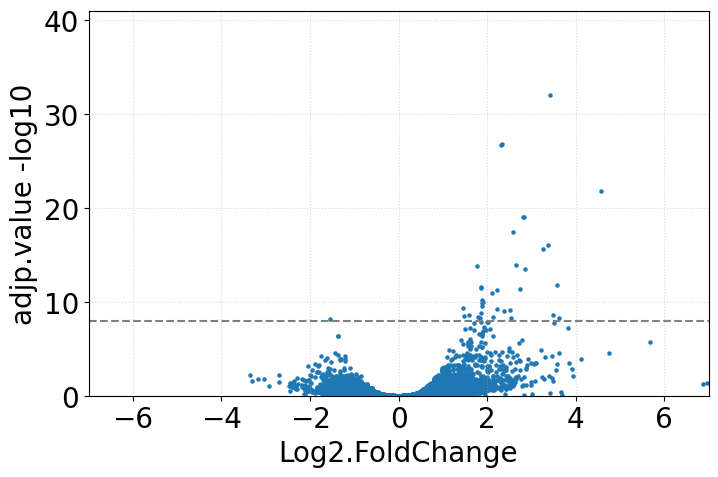

In [30]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df_anno['log2FoldChange'],y=df_anno['padj'].apply(lambda x:-numpy.log10(x)),s=5)

# plt.legend(fontsize = '14')
plt.xlim(-7, 7)
plt.ylim(0, 41)
plt.xlabel("Log2.FoldChange")
plt.ylabel("adjp.value -log10")

# pvalue <0.05
plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")

# title_file = 'volcano_'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## 2- The same but based on the transcripts type?

In [31]:
df_signif['Transcript type'].value_counts()

protein_coding                        430
protein_coding_CDS_not_defined         99
retained_intron                        82
nonsense_mediated_decay                66
transcribed_unprocessed_pseudogene      7
unprocessed_pseudogene                  6
lncRNA                                  5
processed_pseudogene                    5
non_stop_decay                          1
transcribed_unitary_pseudogene          1
Name: Transcript type, dtype: int64

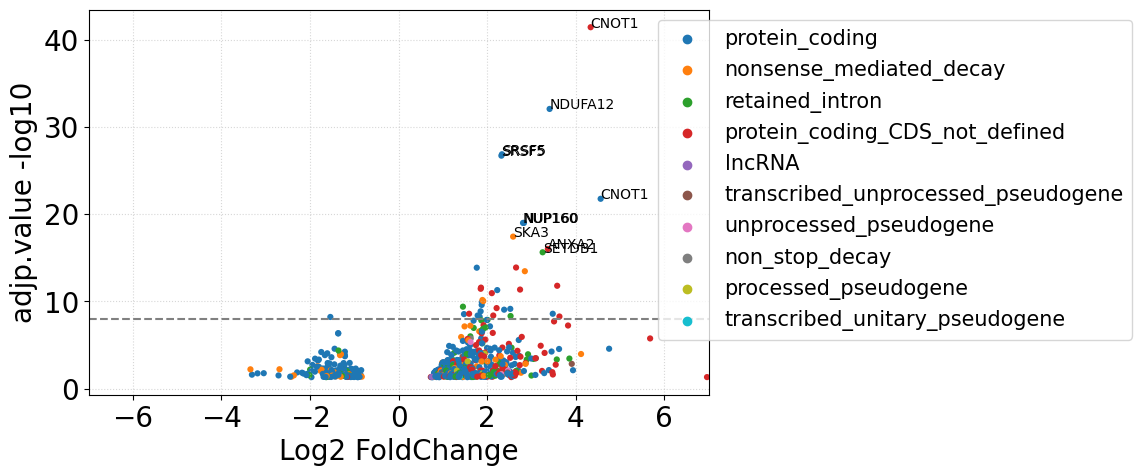

In [32]:
# Top 15 rows
top_15 = df_signif.sort_values(by='padj', ascending=True).head(10)

seaborn.scatterplot(data=df_signif, x=df_signif['log2FoldChange'], 
                    y=df_signif['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

# Annotate points on the plot with Symbol names
for index, row in top_15.iterrows():
    plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                fontsize = 10)

plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")

plt.xlim(-7, 7)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_signif_pertype'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [33]:
# check up
df_signif.sort_values('padj', ascending = True).head(15)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000569263,CNOT1,CNOT1-217,ENSG00000125107,protein_coding,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...,315.814365,4.338181,0.301606,14.383589,6.560270e-47,3.824506e-42
ENST00000547157,NDUFA12,NDUFA12-204,ENSG00000184752,protein_coding,protein_coding,NADH:ubiquinone oxidoreductase subunit A12 [So...,419.398074,3.411533,0.267534,12.751785,3.046869e-37,8.881318e-33
ENST00000553521,SRSF5,SRSF5-203,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2322.642416,2.335998,0.198832,11.748586,7.181006e-32,1.395461e-27
ENST00000557154,SRSF5,SRSF5-217,ENSG00000100650,protein_coding,protein_coding,serine and arginine rich splicing factor 5 [So...,2179.685527,2.322788,0.198650,11.692848,1.386568e-31,2.020853e-27
ENST00000569020,CNOT1,CNOT1-215,ENSG00000125107,protein_coding,protein_coding,CCR4-NOT transcription complex subunit 1 [Sour...,82.112140,4.563910,0.428002,10.663288,1.511578e-26,1.762439e-22
ENST00000694867,NUP160,NUP160-213,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,160.701219,2.810951,0.280511,10.020813,1.234826e-23,1.028399e-19
ENST00000526870,NUP160,NUP160-203,ENSG00000030066,protein_coding,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...,162.744390,2.831842,0.282236,10.033591,1.084971e-23,1.028399e-19
ENST00000465471,SKA3,SKA3-205,ENSG00000165480,protein_coding,nonsense_mediated_decay,spindle and kinetochore associated complex sub...,441.871689,2.587981,0.268368,9.643391,5.242684e-22,3.820475e-18
ENST00000560495,ANXA2,ANXA2-234,ENSG00000182718,protein_coding,protein_coding_CDS_not_defined,annexin A2 [Source:HGNC Symbol;Acc:HGNC:537],89.766880,3.372558,0.362979,9.291319,1.523884e-20,9.871043e-17


## 3- Do we confirm that we have lower protein coding transcripts at 32°?

In [34]:
df_protcoding = df_anno[(df_anno['Transcript type'] == 'protein_coding') | 
                        (df_anno['Transcript type'] == 'protein_coding_CDS_not_defined')]
print(f'{len(df_protcoding)} protein coding transcripts')

downregu = len(df_protcoding[df_protcoding['log2FoldChange'] < 0])
upregu = len(df_protcoding[df_protcoding['log2FoldChange'] > 0])

print(f'{downregu} are downregulated at 32°')
print(f'{upregu} are upregulated at 32°')

46871 protein coding transcripts
23773 are downregulated at 32°
23098 are upregulated at 32°


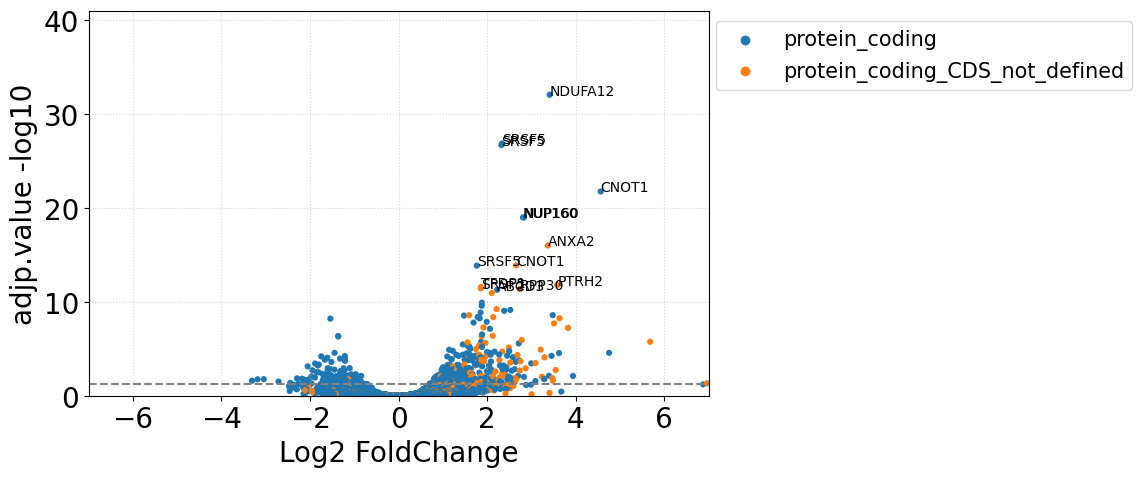

In [35]:
# Top 15 rows
top_15 = df_protcoding.sort_values(by='padj', ascending=True).head(15)

seaborn.scatterplot(data=df_protcoding, x=df_protcoding['log2FoldChange'], 
                    y=df_protcoding['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

# Annotate points on the plot with Symbol names
for index, row in top_15.iterrows():
    plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

plt.ylim(0, 41)
plt.xlim(-7, 7)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_protein_coding_signif_pertype'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [36]:
df_protcoding = df_signif[(df_signif['Transcript type'] == 'protein_coding') | 
                        (df_signif['Transcript type'] == 'protein_coding_CDS_not_defined')]
print(f'{len(df_protcoding)} protein coding transcripts')

downregu = len(df_protcoding[df_protcoding['log2FoldChange'] < 0])
upregu = len(df_protcoding[df_protcoding['log2FoldChange'] > 0])

print(f'{downregu} are downregulated at 32°')
print(f'{upregu} are upregulated at 32°')

529 protein coding transcripts
134 are downregulated at 32°
395 are upregulated at 32°


## 4- What are the highest differentially expressed transcripts?

Text(0, 0.5, 'adjp.value -log10')

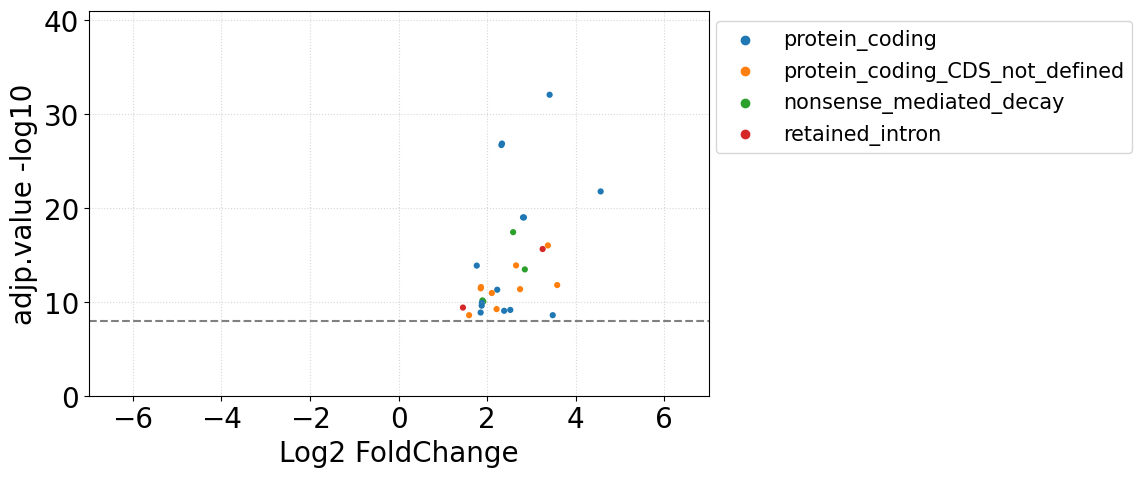

In [37]:
# Top 30 rows are reprensented in the heatmap
top_15 = df_signif.sort_values(by='padj', ascending=True).head(30)

seaborn.scatterplot(data=top_15, x=df_signif['log2FoldChange'], 
                    y=df_signif['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Transcript type")

# Annotate points on the plot with Symbol names
plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1), fontsize='15')

plt.axhline(-numpy.log10(1e-08),color="grey",linestyle="--")
plt.xlim(-7, 7)
plt.ylim(0, 41)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

In [38]:
#select the interesting genes
df_hm = df_signif.sort_values(by='padj', ascending=True).head(30)

max_pval = df_hm['padj'].max()
print(f'highest adj-pvalue is {max_pval}')

df_hm = df_hm[['Transcript name', 'log2FoldChange']]
df_hm.set_index('Transcript name', drop = True, inplace= True)

print(f"max is {df_hm['log2FoldChange'].max()}, min is {df_hm['log2FoldChange'].min()}")
df_hm.head()

highest adj-pvalue is 2.6508916191396345e-09
max is 4.563909853665846, min is 1.4545607221152226


,log2FoldChange
Transcript name,
CNOT1-217,4.338181
NDUFA12-204,3.411533
SRSF5-203,2.335998
SRSF5-217,2.322788
CNOT1-215,4.563910


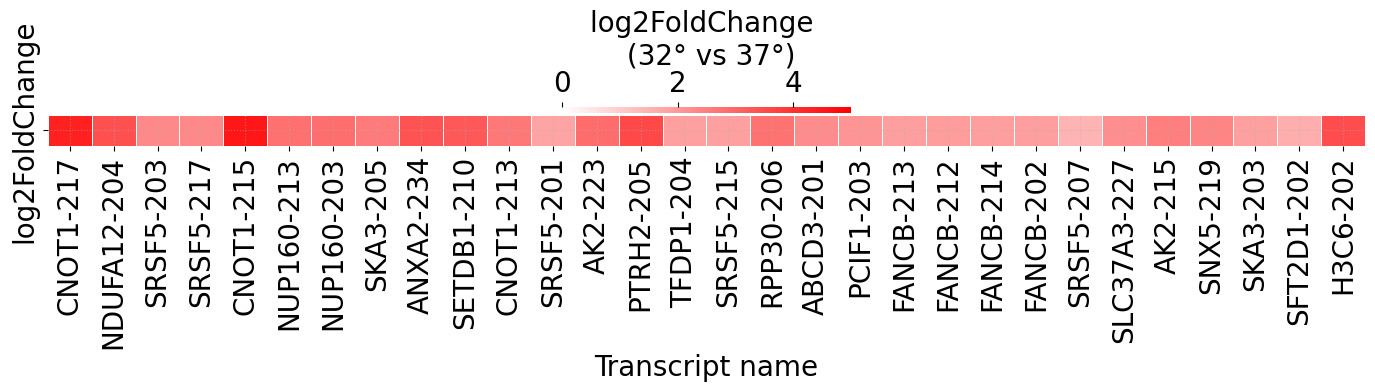

In [39]:
plt.subplots(figsize=(17,0.5))
seaborn.heatmap(df_hm.T, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=0, vmax=5,
               cbar_kws={'label': 'log2FoldChange \n (32° vs 37°)', 'location' : 'top', 'orientation': 'horizontal',
                        'aspect': 50})

title_file = 'heatmap_HEK293_transcriptome'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [40]:
#select the interesting genes
df_hm_details = df_signif.sort_values(by='padj', ascending=True).head(30)
represented_genes = df_hm_details['Gene name'].unique()
print(represented_genes)
# numpy.savetxt(file_directory+"3) output/top30_transcripts_genes_name_HEK293.txt", 
#               represented_genes, delimiter="\t", fmt="% s")

df_hm_details[['Gene name', 'Transcript name', 'Transcript type', 'Gene description']].head(30)

['CNOT1' 'NDUFA12' 'SRSF5' 'NUP160' 'SKA3' 'ANXA2' 'SETDB1' 'AK2' 'PTRH2'
 'TFDP1' 'RPP30' 'ABCD3' 'PCIF1' 'FANCB' 'SLC37A3' 'SNX5' 'SFT2D1' 'H3C6']


,Gene name,Transcript name,Transcript type,Gene description
transcript_id,,,,
ENST00000569263,CNOT1,CNOT1-217,protein_coding_CDS_not_defined,CCR4-NOT transcription complex subunit 1 [Sour...
ENST00000547157,NDUFA12,NDUFA12-204,protein_coding,NADH:ubiquinone oxidoreductase subunit A12 [So...
ENST00000553521,SRSF5,SRSF5-203,protein_coding,serine and arginine rich splicing factor 5 [So...
ENST00000557154,SRSF5,SRSF5-217,protein_coding,serine and arginine rich splicing factor 5 [So...
ENST00000569020,CNOT1,CNOT1-215,protein_coding,CCR4-NOT transcription complex subunit 1 [Sour...
ENST00000694867,NUP160,NUP160-213,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...
ENST00000526870,NUP160,NUP160-203,protein_coding,nucleoporin 160 [Source:HGNC Symbol;Acc:HGNC:1...
ENST00000465471,SKA3,SKA3-205,nonsense_mediated_decay,spindle and kinetochore associated complex sub...
ENST00000560495,ANXA2,ANXA2-234,protein_coding_CDS_not_defined,annexin A2 [Source:HGNC Symbol;Acc:HGNC:537]


## 5- Where are the DEG in the in the DEtranscripts ?

In [41]:
top15_genes_HEK293 = file_directory+"3) output/top15_genes_HEK293.txt"
top5_negative_genes_HEK293 = file_directory+"3) output/top5_negative_genes_HEK293.txt"

with open(top15_genes_HEK293) as f:
    top15_genes_HEK293 = f.read().splitlines()
    
with open(top5_negative_genes_HEK293) as f:
    top5_negative_genes_HEK293 = f.read().splitlines()

In [42]:
DEG_list = top15_genes_HEK293 + top5_negative_genes_HEK293
len(DEG_list)

20

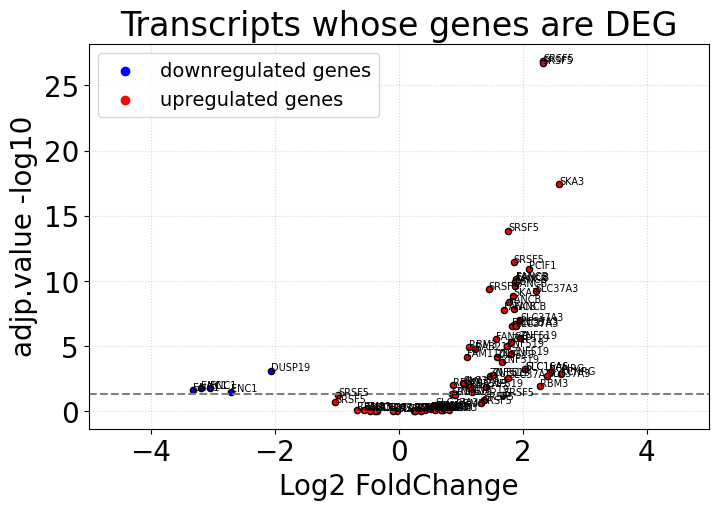

In [44]:
df_onlyDEG = df_anno[df_anno['Gene name'].isin(DEG_list)]

seaborn.scatterplot(data=df_onlyDEG, 
                    x=df_onlyDEG['log2FoldChange'], 
                    y=df_onlyDEG['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', color='white')

plt.scatter(x=[],y=[], marker="o", color='blue', label= 'downregulated genes')
plt.scatter(x=[],y=[], marker="o", color='red', label= 'upregulated genes')

# Annotate the DEGene
## upregulated one
for index, row in df_onlyDEG.iterrows():
    if row['Gene name'] in top15_genes_HEK293:
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='red', edgecolor='black') 
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=7, color='k')
        
    elif row['Gene name'] in top5_negative_genes_HEK293:
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='blue', edgecolor='black')  # Change 'red' to your desired color
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=7, color='k')


plt.legend(fontsize = '14')        
        
        
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

plt.title('Transcripts whose genes are DEG')
plt.xlim(-5, 5)
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_onlyDEG'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [205]:
#What genes are not represented
df_anno['Gene name']
final_ = set(df_onlyDEG['Gene name'])
posDEG_ = set(top15_genes_HEK293)
negDEG_ = set(top5_negative_genes_HEK293)

print(f'The negative genes not in the transcriptome: {negDEG_.symmetric_difference(final_) & negDEG_}')
print(f'The positive genes not in the transcriptome: {posDEG_.symmetric_difference(final_) & posDEG_}')

The negative genes not in the transcriptome: {'FAM110A', 'TFEB', 'INSC'}
The positive genes not in the transcriptome: {'HIST1H3E', 'FAM110D', 'AC011043.1', 'RP11-585F1.6'}


## 6- Where are RBM3, CIRBP and RTN3? 

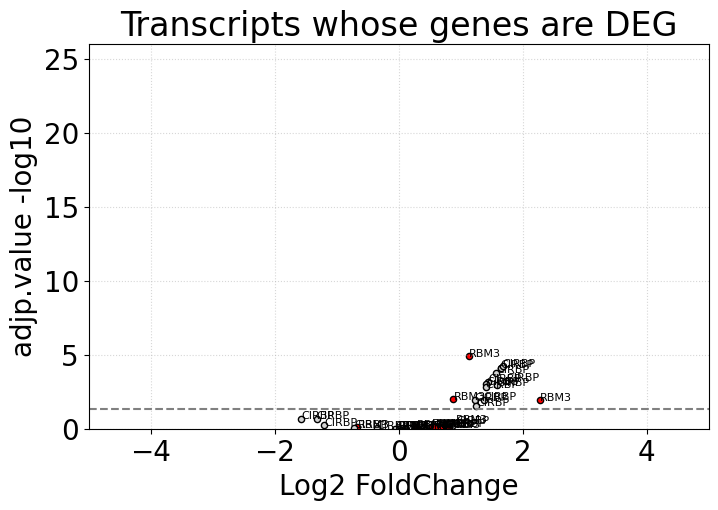

In [45]:
# where are RBM3, CIRBP and RTN3? 
target_genes = ['RBM3', 'CIRBP', 'RTN3']

df_target = df_anno[df_anno['Gene name'].isin(target_genes)]

seaborn.scatterplot(data=df_target, 
                    x=df_target['log2FoldChange'], 
                    y=df_target['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', color='white')

# Annotate the DEGene
## upregulated one
for index, row in df_target.iterrows():
    if row['Gene name'] == 'RBM3':
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='red', edgecolor='black') 
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=8, color='k')
                
    elif row['Gene name'] in ['CIRBP', 'RTN3']:
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='lightgrey', edgecolor='black')  # Change 'red' to your desired color
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=8, color='k')
        
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

plt.title('Transcripts whose genes are DEG')
plt.xlim(-5, 5)
plt.ylim(0, 26)
plt.xlim()
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_targets'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [207]:
len(df_anno[df_anno['Gene name'] == 'CIRBP'])

27

## 7- How genes with loss of H3K36me3 at 32°C expresse their protoding transcripts ?

In [47]:
#data HEK293 H3K36me3_topgenes (positive are gain of H3K36, negative is loss)
H3K36me3_topgenes = pandas.read_csv(file_directory+'1) input/from_output/HEK293_H3K36me3_topgenes.csv',
                     sep = ',')
print(len(H3K36me3_topgenes))

H3K36me3_topgenes = H3K36me3_topgenes.sort_values('Fold', ascending = True)
H3K36me3_topgenes.tail()

112


,SYMBOL,Fold,p.value
6,SREBF2,5.231205,8.312780e-08
4,THOC2,5.352110,6.949019e-08
2,TFB1M,5.448008,3.712064e-08
0,MIR4289,5.552725,2.461157e-08
1,MEX3C,5.621872,2.475970e-08


In [48]:
target_genes = H3K36me3_topgenes['SYMBOL'].unique()
df_target = df_protcoding[df_protcoding['Gene name'].isin(target_genes)]

print(f'{len(df_target)} protein coding transcripts are from gene with loss of H3K36')

print(H3K36me3_topgenes[H3K36me3_topgenes['SYMBOL'].isin(['SREK1', 'ASCC3'])],'\n','\n','\n', df_target)

2 protein coding transcripts are from gene with loss of H3K36
   SYMBOL      Fold   p.value
32  ASCC3 -4.368663  0.000001
79  SREK1 -3.912060  0.000010 
 
 
                 Gene name Transcript name          gene_id       Gene type  \
transcript_id                                                                
ENST00000334121     SREK1       SREK1-202  ENSG00000153914  protein_coding   
ENST00000369143     ASCC3       ASCC3-203  ENSG00000112249  protein_coding   

                Transcript type  \
transcript_id                     
ENST00000334121  protein_coding   
ENST00000369143  protein_coding   

                                                  Gene description  \
transcript_id                                                        
ENST00000334121  splicing regulatory glutamic acid and lysine r...   
ENST00000369143  activating signal cointegrator 1 complex subun...   

                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
transcript_id                 

In [49]:
df_target

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000334121,SREK1,SREK1-202,ENSG00000153914,protein_coding,protein_coding,splicing regulatory glutamic acid and lysine r...,282.039426,-0.934280,0.254036,-3.677743,0.000235,0.025834
ENST00000369143,ASCC3,ASCC3-203,ENSG00000112249,protein_coding,protein_coding,activating signal cointegrator 1 complex subun...,91.060737,1.251637,0.299102,4.184649,0.000029,0.005883


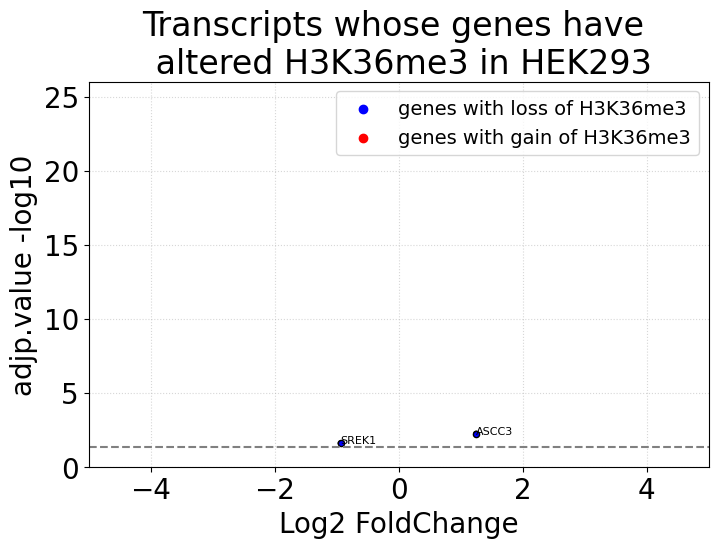

In [50]:
seaborn.scatterplot(data=df_target, 
                    x=df_target['log2FoldChange'], 
                    y=df_target['padj'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', color='k')

plt.scatter(x=[],y=[], marker="o", color='blue', label= 'genes with loss of H3K36me3')
plt.scatter(x=[],y=[], marker="o", color='red', label= 'genes with gain of H3K36me3')
# Annotate the DEGene
## upregulated one
for index, row in df_target.iterrows():
    if row['Gene name'] in set(H3K36me3_topgenes[H3K36me3_topgenes['Fold'] > 0]['SYMBOL']):
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='red', edgecolor='black') 
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=8, color='red')
                
    elif row['Gene name'] in set(H3K36me3_topgenes[H3K36me3_topgenes['Fold'] < 0]['SYMBOL']):
        plt.scatter(x=row['log2FoldChange'], y= -numpy.log10(row['padj']), 
                    s=20, color='blue', edgecolor='black')  # Change 'red' to your desired color
        plt.annotate(row['Gene name'], (row['log2FoldChange'], -numpy.log10(row['padj'])),
                     fontsize=8, color='k')
        
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.legend(fontsize= 14)
plt.title('Transcripts whose genes have \n altered H3K36me3 in HEK293')
plt.xlim(-5, 5)
plt.ylim(0, 26)
plt.xlim()
plt.xlabel("Log2 FoldChange")
plt.ylabel("adjp.value -log10")

title_file = 'volcano_HEK_transcriptome_targets'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [51]:
target_genes = H3K36me3_topgenes['SYMBOL'].unique()
df_target = df_anno[df_anno['Gene name'].isin(target_genes)]
print(f'{len(df_target)} transcripts are from gene with loss of H3K36 (non prot_cod)')
print(f'the lower adj-pvalue found is {df_target.padj.round(2).min()}')

617 transcripts are from gene with loss of H3K36 (non prot_cod)
the lower adj-pvalue found is 0.01
